In [57]:
import itertools
from ortools.sat.python import cp_model
import random
import numpy as np

In [60]:
def solve_fjs_with_parallel_machines(jobs_data,
                                     release_dates,
                                     due_dates,
                                     weights,
                                     setup_times,
                                     center_caps):
    model = cp_model.CpModel()

    # 1. 生成實體機台
    machines, center_of = [], {}
    for p, cap in center_caps.items():
        for k in range(cap):
            m = f"{p}_{k}"
            machines.append(m)
            center_of[m] = p

    # 2. 決策變數
    horizon = sum(d for ops in jobs_data.values() for d,_ in ops) + max(due_dates.values())
    start, end, assign, tardiness = {}, {}, {}, {}

    for j, ops in jobs_data.items():
        for o, (dur, centers) in enumerate(ops):
            start[j, o] = model.NewIntVar(0, horizon, f"s_j{j}o{o}")
            end[j, o]   = model.NewIntVar(0, horizon, f"e_j{j}o{o}")
            # 只為允許的機台建 assign 變數
            valid = [m for m in machines if center_of[m] in centers]
            bools = []
            for m in valid:
                b = model.NewBoolVar(f"a_j{j}o{o}_m{m}")
                assign[j, o, m] = b
                bools.append(b)
                model.Add(end[j, o] == start[j, o] + dur).OnlyEnforceIf(b)
            model.AddExactlyOne(bools)

    # 3. 釋放時間與工序順序
    for j in jobs_data:
        model.Add(start[j, 0] >= release_dates[j])
        for o in range(len(jobs_data[j]) - 1):
            model.Add(start[j, o+1] >= end[j, o])

    # 4. 機台互斥 + 序依換線
    for m in machines:
        tasks = [(j, o) for j, ops in jobs_data.items()
                        for o, (_, centers) in enumerate(ops)
                        if center_of[m] in centers]
        for (j1, o1), (j2, o2) in itertools.combinations(tasks, 2):
            b = model.NewBoolVar(f"ord_{j1}o{o1}_{j2}o{o2}_on_{m}")
            p = center_of[m]
            s12 = setup_times.get(p, {}).get(((j1, o1), (j2, o2)), 0)
            s21 = setup_times.get(p, {}).get(((j2, o2), (j1, o1)), 0)

            model.Add(start[j2, o2] >= end[j1, o1] + s12)\
                 .OnlyEnforceIf([assign[j1, o1, m],
                                 assign[j2, o2, m], b])
            model.Add(start[j1, o1] >= end[j2, o2] + s21)\
                 .OnlyEnforceIf([assign[j1, o1, m],
                                 assign[j2, o2, m], b.Not()])

    # 5. 拖期與目標
    for j, ops in jobs_data.items():
        last = len(ops) - 1
        tardiness[j] = model.NewIntVar(0, horizon, f"T_j{j}")
        model.Add(tardiness[j] >= end[j, last] - due_dates[j])
    model.Minimize(sum(weights[j] * tardiness[j] for j in jobs_data))

    # 6. 求解
    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = 10
    status = solver.Solve(model)

    if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
        schedule = {}
        for j, ops in jobs_data.items():
            schedule[j] = []
            for o in range(len(ops)):
                st = solver.Value(start[j, o])
                en = solver.Value(end[j, o])
                # 只在 assign 有定義的機台中找被選中的那一台
                m_assigned = next(
                    m for m in machines
                    if (j, o, m) in assign
                    and solver.Value(assign[j, o, m]) == 1
                )
                schedule[j].append((o, m_assigned, st, en))
        return schedule, solver.ObjectiveValue()

    return None, None

def generate_random_instance(num_jobs = 10, centers = ('C1','C2','C3',"C4"),
                             center_caps = {'C1':3,'C2':2,'C3':3,"C4":2},
                             num_ops = {'C1':4,'C2':3,'C3':2,"C4":1}):

    jobs_data, release_dates, due_dates, weights = {}, {}, {}, {}
    setup_times = {p:{} for p in centers}

    for j in range(num_jobs):
        ops = []
        for c in centers:
            for _ in range(num_ops[c]):
                dur = random.randint(1, 10)
                ops.append((dur, c))

        jobs_data[j] = ops
        due_dates[j]     = random.randint(50, 200)
        release_dates[j] = random.randint(0, due_dates[j] // 2)
        weights[j]       = random.randint(1, 5)

    # 隨機設定序依換線時間
    for p in centers:
        all_ops = [(j, o) for j, ops in jobs_data.items()
                          for o in range(len(ops))
                          if p in ops[o][1]]
        for (j1,o1),(j2,o2) in itertools.permutations(all_ops, 2):
            setup_times[p][((j1,o1),(j2,o2))] = random.randint(0, 3)

    return jobs_data, release_dates, due_dates, weights, setup_times, center_caps

if __name__ == "__main__":
    # 1. 生成隨機實例
    random.seed(42)
    jobs_data, release_dates, due_dates, weights, setup_times, center_caps = \
        generate_random_instance()

    # 2. 求解
    schedule, obj = solve_fjs_with_parallel_machines(
        jobs_data, release_dates, due_dates, weights, setup_times, center_caps
    )

    # 3. 輸出結果
    print(jobs_data)
    print(f"Jobs: {len(jobs_data)}, Centers: {center_caps}")
    print(f"Objective Σ wj·Tj = {obj}\n")
    print("Job 排程 (job, op, machine, start, end):")
    print(schedule)

{0: [(2, 'C1'), (1, 'C1'), (5, 'C1'), (4, 'C1'), (4, 'C2'), (3, 'C2'), (2, 'C2'), (9, 'C3'), (2, 'C3'), (10, 'C4')], 1: [(2, 'C1'), (4, 'C1'), (4, 'C1'), (9, 'C1'), (10, 'C2'), (1, 'C2'), (9, 'C2'), (4, 'C3'), (9, 'C3'), (7, 'C4')], 2: [(5, 'C1'), (1, 'C1'), (3, 'C1'), (7, 'C1'), (6, 'C2'), (5, 'C2'), (3, 'C2'), (4, 'C3'), (6, 'C3'), (2, 'C4')], 3: [(6, 'C1'), (6, 'C1'), (10, 'C1'), (5, 'C1'), (1, 'C2'), (8, 'C2'), (9, 'C2'), (2, 'C3'), (7, 'C3'), (2, 'C4')], 4: [(6, 'C1'), (10, 'C1'), (4, 'C1'), (2, 'C1'), (1, 'C2'), (4, 'C2'), (5, 'C2'), (2, 'C3'), (4, 'C3'), (2, 'C4')], 5: [(6, 'C1'), (3, 'C1'), (6, 'C1'), (6, 'C1'), (4, 'C2'), (5, 'C2'), (2, 'C2'), (10, 'C3'), (3, 'C3'), (9, 'C4')], 6: [(7, 'C1'), (5, 'C1'), (9, 'C1'), (4, 'C1'), (6, 'C2'), (1, 'C2'), (4, 'C2'), (1, 'C3'), (6, 'C3'), (7, 'C4')], 7: [(10, 'C1'), (6, 'C1'), (4, 'C1'), (8, 'C1'), (7, 'C2'), (8, 'C2'), (3, 'C2'), (5, 'C3'), (3, 'C3'), (4, 'C4')], 8: [(10, 'C1'), (7, 'C1'), (10, 'C1'), (7, 'C1'), (6, 'C2'), (4, 'C2'), (

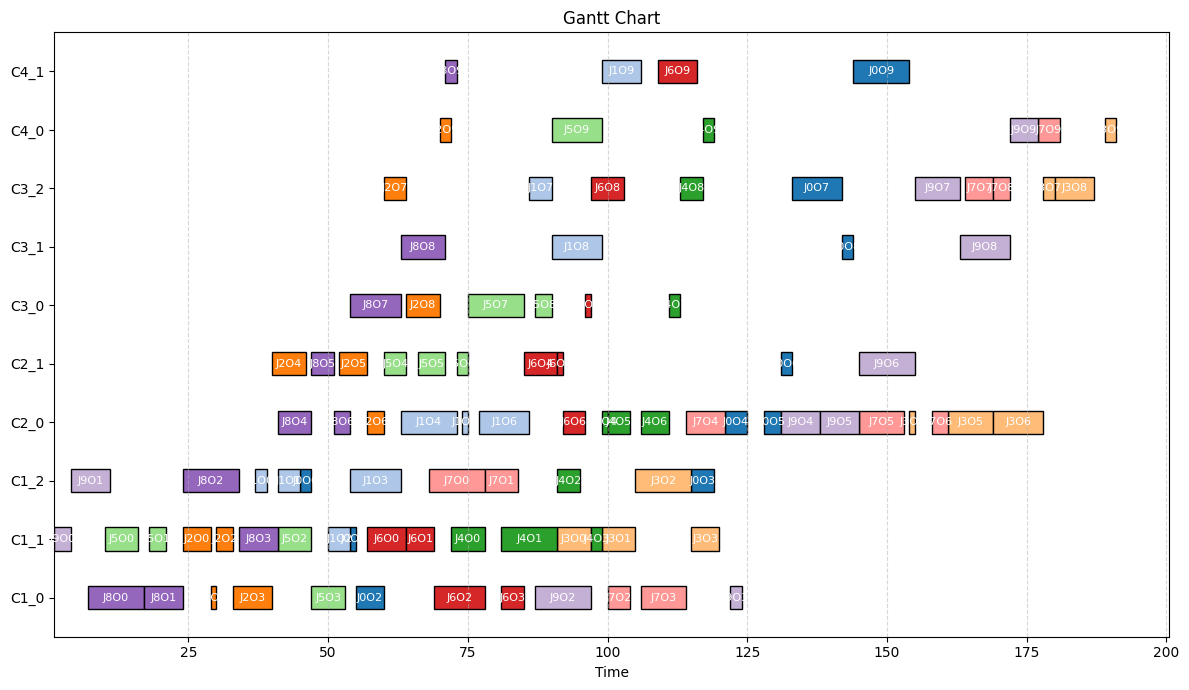

In [43]:
import matplotlib.pyplot as plt

def plot_gantt(schedule,
               title="Gantt Chart",
               filename=None):
    """
    schedule: dict
        { job_id: [ (op_idx, machine, start, end), ... ], ... }
    title: str
    filename: str or None, 若指定則儲存成檔案

    依機台排序繪製每個工序的水平長條，並於中間標上 JxOy。
    """
    # 1. 準備 y 軸：機台列表與對應座標
    machines = sorted({ m for ops in schedule.values() for _, m, _, _ in ops })
    y_pos = { m: i for i, m in enumerate(machines) }

    # 2. 顏色映射 (以 job_id 分組上色)
    cmap = plt.get_cmap("tab20")
    job_ids = sorted(schedule)
    color_map = { j: cmap(i % 20) for i, j in enumerate(job_ids) }

    # 3. 繪圖
    fig, ax = plt.subplots(figsize=(12, len(machines)*0.6+1))
    for j, ops in schedule.items():
        for op_idx, m, st, en in ops:
            ax.barh(y_pos[m],
                    en - st,
                    left=st,
                    height=0.4,
                    color=color_map[j],
                    edgecolor="black")
            ax.text(st + (en-st)/2,
                    y_pos[m],
                    f"J{j}O{op_idx}",
                    ha="center",
                    va="center",
                    color="white",
                    fontsize=8)

    # 4. 美化
    ax.set_yticks(list(y_pos.values()))
    ax.set_yticklabels(machines)
    ax.set_xlabel("Time")
    ax.set_title(title)
    ax.grid(axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()

    # 5. 顯示或儲存
    if filename:
        plt.savefig(filename, dpi=200)
        print(f"甘特圖已儲存為 {filename}")
    plt.show()

plot_gantt(schedule)

In [44]:
class SchedulingProblem:
    def __init__(self, jobs_data, release_dates, due_dates,
                 weights, setup_times, center_caps):
        self.jobs_data = jobs_data
        self.release = release_dates
        self.due_dates = due_dates
        self.weights = weights
        self.setup_times = setup_times
        self.center_caps = center_caps

    def encode(self, seed_solution = None):
        machine_assign = {}
        priorities = {}

        if seed_solution:
            ma_seed, pr_seed = seed_solution
            machine_assign = ma_seed.copy()
            priorities     = pr_seed.copy()
        else:
            for j, ops in self.jobs_data.items():
                base = random.random()
                for o in range(len(ops)):
                    centers = self.jobs_data[j][o][1]
                    p = random.choice([centers])
                    k = random.randrange(self.center_caps[p])
                    machine_assign[(j,o)] = f"{p}_{k}"
                    priorities[(j,o)] = base + 0.001 * o

        return machine_assign, priorities

    def decode(self, machine_assign, priorities):
        machines = []

        for c, cap in center_caps.items():
            for k in range(cap):
                machines.append(f"{c}_{k}")

        mc_timeline = {m:[] for m in machines}
        doc_times = {}
        ops_sorted = sorted(priorities.items(), key = lambda x: x[1])

        for (j, o), _ in ops_sorted:
            m = machine_assign[(j,o)]
            p = m.split('_')[0]
            duration, _ = self.jobs_data[j][o]

            t = self.release[j]
            if o > 0:
                prev_end = doc_times[(j, o-1)][1]
                t = max(t, prev_end)

            timeline = sorted(mc_timeline[m], key = lambda x: x[0])
            for prev_end, prev_op in timeline:
                s = self.setup_times.get(p, {}).get((prev_op, (j,o)), 0)
                t = max(t, prev_end + s)

            start, end = t, t + duration
            mc_timeline[m].append((end, (j,o)))
            doc_times[(j,o)] = (start, end)

        obj = 0
        for j, ops in self.jobs_data.items():
            last_endtime = doc_times[(j, len(ops)-1)][1]
            obj += self.weights[j] * max(0, last_endtime - self.due_dates[j])

        return obj

In [45]:
class GeneticAlgorithm:
    def __init__(self, problem, pop_size = 100, max_generations = 50, cross_p = 0.8, mut_p = 0.2):
        self.problem = problem
        self.pop_size = pop_size
        self.gen_max = max_generations
        self.cross_p = cross_p
        self.mut_p = mut_p
        self.population = []

    def init_population(self, seed_solution):
        self.population.append(self.problem.encode(seed_solution))
        for _ in range(self.pop_size - 1):
            self.population.append(self.problem.encode())

    def evaluate_fitness(self, target):
        fitness = self.problem.decode(target[0], target[1])
        return fitness

    def mutate(self, target):
        new_target = target
        ops = list(new_target[1])
        if random.random() < self.mut_p:
            j,o = random.choice(ops)
            centers = self.problem.jobs_data[j][o][1]
            p = random.choice([centers])
            k = random.randrange(self.problem.center_caps[p])
            new_target[0][(j,o)] = f"{p}_{k}"

        if random.random() < self.mut_p:
            j, _ = random.choice(ops)
            base = random.random()
            for o in range(len(self.problem.jobs_data[j])):
                new_target[1][(j,o)] = base + 0.001 * o

        return new_target

    def linear_order_crossover(self, parent1, parent2):
        jobs = list(self.problem.jobs_data.keys())
        size = len(jobs)
        start, end = sorted(random.sample(range(size), 2))

        # Step 1: 拿一段 job base 排序片段
        segment_jobs = jobs[start:end+1]
        segment_bases = {j: parent1[1][(j, 0)] for j in segment_jobs}

        # Step 2: 剩餘 job 由 parent2 補完，保持原順序
        remainder_jobs = [j for j in jobs if j not in segment_jobs]
        remainder_bases = {j: parent2[1][(j, 0)] for j in remainder_jobs}

        # Step 3: 合併 base 順序
        job_order = remainder_jobs[:start] + segment_jobs + remainder_jobs[start:]
        combined_bases = {**remainder_bases, **segment_bases}

        # Step 4: 為每個 job 建立 priority[(j,o)]，保工序順序
        child_priority = {}
        for j in job_order:
            base = combined_bases[j]
            for o in range(len(self.problem.jobs_data[j])):
                child_priority[(j, o)] = base + 0.001 * o

        child = (parent1[0], child_priority)
        child = self.mutate(child)

        return child

    def roulette_selection(self, number = 2):
        fitness_values = [1.0 / (self.evaluate_fitness(target) + 1e-6) for target in self.population]
        total_fitness = sum(fitness_values)
        probabilities = [f / total_fitness for f in fitness_values]
        cumulative_probs = []
        cumulative = 0.0
        for p in probabilities:
            cumulative += p
            cumulative_probs.append(cumulative)

        res = []
        for _ in range(number):
            spin = random.random()
            for i, cp in enumerate(cumulative_probs):
                if spin <= cp:
                    res.append(self.population[i])
                    break
        return res

    def run(self, seed_solution):
        self.init_population(seed_solution)
        best = None
        best_obj = float('inf')

        for _ in range(self.gen_max):
            for target in self.population:
                obj = self.evaluate_fitness(target)
                if obj < best_obj:
                    best_obj, best = obj, target

            next_pop = []
            while len(next_pop) < self.pop_size:
                p1, p2 = self.roulette_selection()

                if random.random() < self.cross_p:
                    c1 = self.linear_order_crossover(p1, p2)
                    c2 = self.linear_order_crossover(p1, p2)
                else:
                    c1, c2 = p1, p2

                next_pop.extend([c1, c2])

            self.population = next_pop[:self.pop_size]

        return best_obj, best

In [46]:
mach0, prio0 = {}, {}
for j, ops in schedule.items():
    for o, m, start, end in ops:
        mach0[(j,o)] = m
        prio0[(j,o)] = start

seed = (mach0, prio0)
problem = SchedulingProblem(jobs_data, release_dates, due_dates, weights, setup_times, center_caps)
GA = GeneticAlgorithm(problem, pop_size = 100, max_generations = 50)
best_obj, best_schedule = GA.run(seed)
print(best_obj)

22


In [47]:
def decode_schedule(jobs_data,
                    release_dates,
                    due_dates,
                    weights,
                    setup_times,
                    machine_assign,
                    priorities):
    """
    將 priority-based GA 染色體轉為可視甘特圖的 schedule。

    Arguments:
      jobs_data: {j: [(duration, [centers]), ...]}
      release_dates: {j: rj}
      due_dates: {j: dj}
      weights: {j: wj}
      setup_times: {p: {((j1,o1),(j2,o2)): s_time}}
      machine_assign: {(j,o): "C1_0", ...}
      priorities: {(j,o): float, ...}
      ε: 微小值，若 priority 相等時作為 tiebreaker

    Returns:
      schedule: { j: [ (o, m, start, end), ... ] }
      so_times: {(j,o): (start, end)}
      objective: float
    """
    # 1. 準備：各機台的時間表
    machines = set(machine_assign.values())
    mc_timeline = {m: [] for m in machines}
    so_times = {}

    # 2. 按 priority 排序所有 (j,o)
    ops = list(priorities.items())
    # 如果 priority 相同，用 (j,o) 做小 tiebreaker
    ops_sorted = sorted(ops, key=lambda x: (x[1], x[0]))

    # 3. 逐一排程
    for (j,o), pr in ops_sorted:
        m = machine_assign[(j,o)]
        # 3.1 計算起始下界 t0
        t0 = release_dates.get(j, 0)
        if o > 0:
            # 前序完成
            prev_en = so_times[(j, o-1)][1]
            t0 = max(t0, prev_en)

        # 3.2 機台上考慮換線與已排工序
        timeline = sorted(mc_timeline[m], key=lambda x: x[0])  # (end_prev,(j_prev,o_prev))
        t = t0
        center = m.split('_')[0]

        for end_prev, prev_op in timeline:
            # 從 prev_op → current op 的換線
            s = setup_times.get(center, {}).get((prev_op, (j,o)), 0)
            # 若 t < end_prev + s，必須推到 end_prev+s
            if t < end_prev + s:
                t = end_prev + s

        # 3.3 計算結束時間並更新
        st, en = t, t + jobs_data[j][o][0]
        so_times[(j,o)] = (st, en)
        mc_timeline[m].append((en, (j,o)))

    # 4. 建立 schedule dict
    schedule = {}
    for (j,o), (st,en) in so_times.items():
        m = machine_assign[(j,o)]
        schedule.setdefault(j, []).append((o, m, st, en))

    return schedule

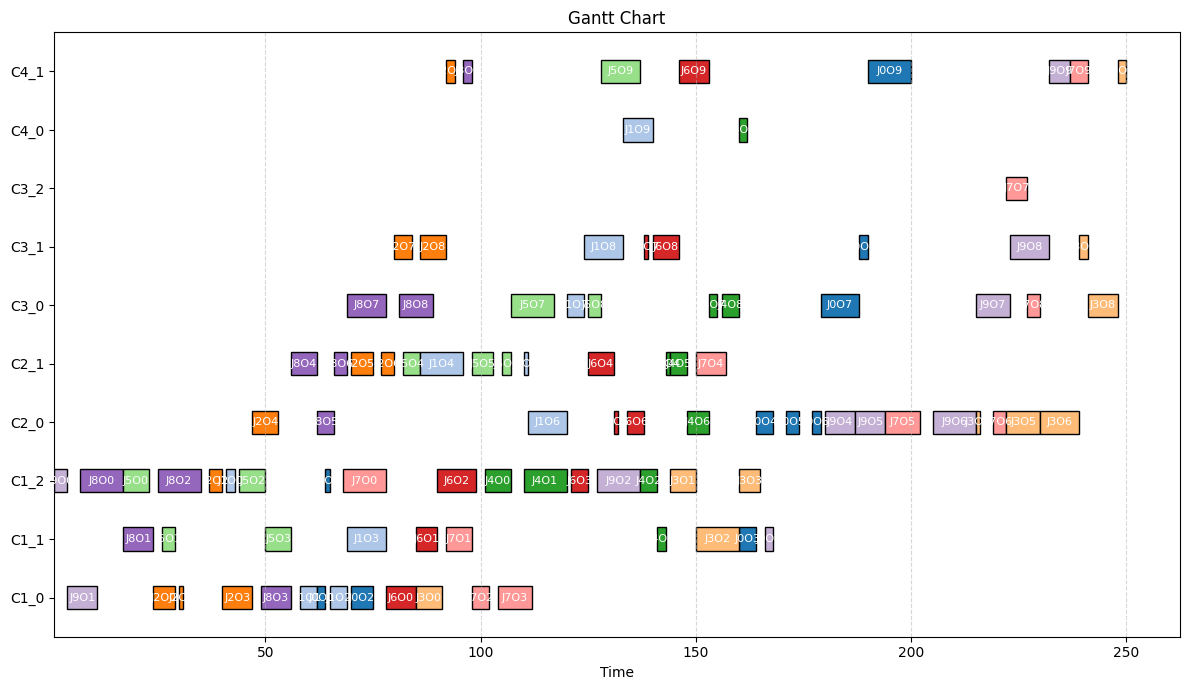

In [48]:
best_schedule = decode_schedule(jobs_data,
                    release_dates,
                    due_dates,
                    weights,
                    setup_times,
                    best_schedule[0],
                    best_schedule[1])

plot_gantt(best_schedule)